In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
import lmfit

from joblib import Parallel, delayed
from scipy.interpolate import RegularGridInterpolator

from scipy.ndimage import gaussian_filter1d

from iminuit import Minuit

In [2]:
pride_palette_balanced = [
    "#3C38A0",  # deep indigo
#    "#7152B8",  # royal purple (new)
    "#1B7A6E",  # lighter teal
    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=pride_palette_balanced)

In [3]:
def read_spe(date, infile):

    os.chdir(date) 
    
    hist_cts = []
    
    with open(infile) as f:
        for lineno, line in enumerate(f):
            if  12 <= lineno < 2060:
                hist_cts.append(float(line.strip()))
    hist_cts = np.array(hist_cts)
    
    os.chdir('..')

    return hist_cts 

def rebin(x, hist, factor):#### counts = hist
    new_x = x[::factor]
    new_hist = hist.reshape(-1, factor).sum(axis=1)
    return new_x, new_hist

def remove_zeros(data, model):
    mask = np.where(data>0)
    data = data[mask]
    model = model[mask]

    return data, model
    

def run_time_cal(bin_cal, time_cal):
   
    num_bins = 2048   
    coeffs = np.polyfit(bin_cal, time_cal, 1)
    a, b = coeffs
    print(f"Linear calibration fit: time = {a:.6e} * bin + {b:.6e}")
    
    bins = np.arange(num_bins)
    timestamps = a * bins + b
    
    print(f"Time range: {timestamps[0]:.3f} to {timestamps[-1]:.3f} (units same as input)")
   
    return timestamps


In [4]:
bin_cal = np.array([328, 720, 1114, 1508, 1902])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)
time_0929 = run_time_cal(bin_cal, time_cal)

bin_cal = np.array([347, 741, 1137, 1532, 1928])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)   
time_1006 = run_time_cal(bin_cal, time_cal)

bin_cal = np.array([336, 729, 1125, 1520, 1915])      # known bin indices
time_cal = np.array([10, 20, 30, 40, 50])   # corresponding times (e.g. ns)
time_1008 = run_time_cal(bin_cal, time_cal)

Linear calibration fit: time = 2.540648e-02 * bin + 1.687021e+00
Time range: 1.687 to 53.694 (units same as input)
Linear calibration fit: time = 2.529722e-02 * bin + 1.237055e+00
Time range: 1.237 to 53.020 (units same as input)
Linear calibration fit: time = 2.532284e-02 * bin + 1.511810e+00
Time range: 1.512 to 53.348 (units same as input)


In [5]:
hist = read_spe('2025-10-01', '1001-speed-10ft-51.0.Spe')
time0510, hist0510 = rebin(time_0929, hist, 32)
N0510 = np.sum(hist0510[1:])
normed0510 = hist0510[1:] / N0510

hist = read_spe('2025-10-06', '1006-speed-10ft-74.8.Spe')
time0748, hist0748 = rebin(time_1006, hist, 32)
N0748 = np.sum(hist0748[1:])
normed0748 = hist0748[1:] / N0748

hist = read_spe('2025-10-01', '1001-speed-10ft-101.3.Spe')
time1013, hist1013 = rebin(time_0929, hist, 32)
N1013 = np.sum(hist1013[1:])
normed1013 = hist1013[1:] / N1013

hist = read_spe('2025-10-08', '1008-speed-10ft-125.0.Spe')
time1250, hist1250 = rebin(time_1008, hist, 32)
N1250 = np.sum(hist1250[1:])
normed1250 = hist1250[1:] / N1250

hist = read_spe('2025-10-06', '1006-speed-10ft-150.5.Spe')
time1505, hist1505 = rebin(time_1006, hist, 32)
N1505 = np.sum(hist1505[1:])
normed1505 = hist1505[1:] / N1505

hist = read_spe('2025-10-08', '1008-speed-10ft-201.0.Spe')
time2010, hist2010 = rebin(time_1008, hist, 32)
N2010 = np.sum(hist2010[1:])
normed2010 = hist2010[1:] / N2010

hist = read_spe('2025-10-07', '1007-speed-10ft-230.2.Spe')
time2302, hist2302 = rebin(time_1006, hist, 32)
N2302 = np.sum(hist2302[1:])
normed2302 = hist2302[1:] / N2302

hist = read_spe('2025-10-08', '1008-speed-10ft-255.0.Spe')
time2550, hist2550 = rebin(time_1008, hist, 32)
N2550 = np.sum(hist2550[1:])
normed2550 = hist2550[1:] / N2550

hist = read_spe('2025-10-01', '1001-speed-10ft-286.2.Spe')
time2862, hist2862 = rebin(time_0929, hist, 32)
N2862 = np.sum(hist2862[1:])
normed2862 = hist2862[1:] / N2862

In [6]:
normed0510.shape

(63,)

In [280]:
def make_template_real(height, betamu, t0, twidth, D, bins):

    c = 299792458/1e9

    width = 0.40
    length = 0.55

    N = 50000

    x1 = np.random.uniform(-width/2 , width/2, N)
    y1 = np.random.uniform(0 , length, N)

    x2 = np.random.uniform(-width/2 , width/2, N)
    y2 = np.random.uniform(0 , length, N)

    L = np.sqrt((x1-y1)**2 + (x2-y2)**2 + height**2)

    vmu = c*betamu
    
    tsignal = np.random.normal(loc=(x2**2 + y2**2 )/2/D, scale=twidth, size=N) - np.random.normal(loc=(x1**2 + y1**2 )/2/D, scale=twidth, size=N)
    
    t = L/vmu  + tsignal + t0

    cos = height/L

    hist_ct, bin_edges = np.histogram(t, bins=bins.shape[0], range = (min(bins), max(bins)), weights=cos**2)

    hist_ct = gaussian_filter1d(hist_ct, 1)

    return hist_ct[1:]/np.sum(hist_ct[1:])
'''
def make_template_real(height, betamu, t0, twidth, D, bins):

    c = 299792458/1e9

    width = 0.40
    length = 0.55

    N = 500000

    x1 = np.random.uniform(-width/2 , width/2, N)
    y1 = np.random.uniform(0 , length, N)

    x2 = np.random.uniform(-width/2 , width/2, N)
    y2 = np.random.uniform(0 , length, N)

    L = np.sqrt((x1-y1)**2 + (x2-y2)**2 + height**2)

    vmu = c*betamu
    
    tsignal = np.random.normal(loc=(x2**2 + y2**2-x1**2 - x2**2 )/2/D, scale=twidth, size=N) 
    t = L/vmu  + tsignal + t0

    cos = height/L

    hist_ct, bin_edges = np.histogram(t, bins=bins.shape[0], range = (min(bins), max(bins)), weights=cos**2)

    hist_ct = gaussian_filter1d(hist_ct, 1)

    return hist_ct[1:]/np.sum(hist_ct[1:])'''

In [ ]:
def make_template_real(height, betamu, t0, twidth, nbins):
    c = 299792458/1e9

    width = 0.40
    length = 0.55

    N = 1000000

    x1 = np.random.uniform(-width/2 , width/2, N)
    y1 = np.random.uniform(0 , length, N)

    x2 = np.random.uniform(-width/2 , width/2, N)
    y2 = np.random.uniform(0 , length, N)

    L = np.sqrt((x1-y1)**2 + (x2-y2)**2 + height**2)

    vmu = c*betamu
    
    t = L/vmu + t0 + np.random.normal(loc = 0, scale = twidth, size = N)

    cos = height/L

    hist_ct, bin_edges = np.histogram(t, bins=nbins, weights=cos**2)

    return hist_ct/np.sum(hist_ct) , bin_edges

In [148]:
betamus = np.linspace(0.8, 1.2, 50)   # reduce points for demo speed
t0s     = np.linspace(18, 21, 20)
twidths = np.linspace(0.01, 4, 20)
Ds      = np.linspace(0.005, 0.04, 20)

In [151]:
def evaluate_and_interp_template(height, betamus, t0s, twidths, Ds, bins):
    
    points = [(bm, t0, tw, D) for bm in betamus
                                for t0 in t0s
                                for tw in twidths
                                for D  in Ds]
    
    results = Parallel(n_jobs=-1, verbose=1)(
        delayed(make_template_real)(height, bm, t0, tw, D, bins) for bm, t0, tw, D in points
    )
    
    # Reshape into 4D array matching parameter grid
    templates = np.array(results).reshape(
        len(betamus), len(t0s), len(twidths), len(Ds),len(bins)-1,
    )

    interp = RegularGridInterpolator(
    (betamus, t0s, twidths, Ds), templates, bounds_error=False, fill_value=None)
    
    return interp

print("Evaluating templates over grid...")
template0510 = evaluate_and_interp_template(0.510, betamus, t0s, twidths, Ds, time0510)
template0748 = evaluate_and_interp_template(0.748, betamus, t0s, twidths, Ds, time0748)
template1013 = evaluate_and_interp_template(1.013, betamus, t0s, twidths, Ds, time1013)
template1250 = evaluate_and_interp_template(1.250, betamus, t0s, twidths, Ds, time1250)
template1505 = evaluate_and_interp_template(1.505, betamus, t0s, twidths, Ds, time1505)
template2010 = evaluate_and_interp_template(2.010, betamus, t0s, twidths, Ds, time2010)
template2302 = evaluate_and_interp_template(2.302, betamus, t0s, twidths, Ds, time2302)
template2550 = evaluate_and_interp_template(2.550, betamus, t0s, twidths, Ds, time2550)
template2862 = evaluate_and_interp_template(2.862, betamus, t0s, twidths, Ds, time2862)
print("Done!")

print(template0510)

Evaluating templates over grid...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1420 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 9420 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 20620 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 35020 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 52620 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 73420 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 97420 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 124620 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 155020 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 188620 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 225420 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 265420 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 308620 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Do

Done!


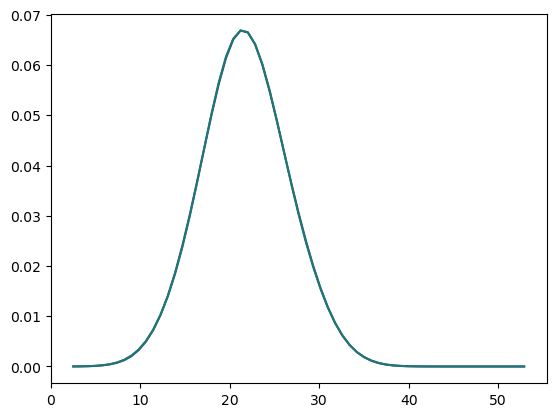

In [152]:
nh = make_template_real( .51, 0.995, 19.6, 2, 0.017, time0510 )
nh_interp = template0510([0.995, 19.6, 2, 0.017])[0]
plt.plot(time0510[1:], nh)
plt.plot(time0510[1:], nh_interp)


In [238]:
def chi2_total(betamu, t0, twidth, D, bkg):    
    
    nh0510 = template0510([betamu, t0, twidth, D])[0]+bkg

    nh0748 = template0748([betamu, t0, twidth, D])[0]+bkg

    nh1013 = template1013([betamu, t0, twidth, D])[0]+bkg

    nh1250 = template1250([betamu, t0, twidth, D])[0]+bkg

    nh1505 = template1505([betamu, t0, twidth, D])[0]+bkg

    nh2010 = template2010([betamu, t0, twidth, D])[0]+bkg

    nh2302 = template2302([betamu, t0, twidth, D])[0]+bkg

    nh2550 = template2550([betamu, t0, twidth, D])[0]+bkg

    nh2862 = template2862([betamu, t0, twidth, D])[0]+bkg

    chi2 = 0

    for datasum, data, model in [ (N0510, normed0510, nh0510), (N0748, normed0748, nh0748), (N1013, normed1013, nh1013), (N1250, normed1250, nh1250), (N1505, normed1505, nh1505), (N2010, normed2010, nh2010), (N2302, normed2302, nh2302), (N2550, normed2550, nh2550), (N2862, normed2862, nh2862) ]:
        data, model = remove_zeros(data, model)
        chi2 += datasum*np.sum((data - model)**2 /data)
    
    return chi2

In [269]:
# Initial guesses and limits
m = Minuit(chi2_total,
           betamu=995.919e-3, t0=18.927, twidth=1.853, D=0.0168, bkg = 0.684e-3)

m.limits = [
    (betamus.min(), betamus.max()),
    (t0s.min(), t0s.max()),
    (twidths.min(), twidths.max()),
    (Ds.min(), Ds.max()), 
    (0,0.1)
]

# Run minimization
m.migrad()  # main minimizer
m.minos()
m.hesse()   # compute errors from curvature

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.045e+04                  │             Nfcn = 1166              │
│ EDM = 0.0319 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ betamu │995.918e-3 │ 0.063e-3  │ -0.058e-3  │  0.005e-3  │   0.8   │   1.2   │       │
│ 1 │ t0     │  18.927   │   0.012   │   -0.012   │   0.012    │   18    │   21    │       │
│ 2 │ twidth │   1.853   │   0.021   │   -0.021   │   0.021    │  0.01   │    4    │       │
│ 3 │ D      │ 16.89e-3  │  0.08e-3  │  -0.08e-3  │  0.08e-3   │  0.005  │  0.04   │       │
│ 4 │ bkg    │ 0.684e-3  │ 0.012e-3  │ -0.012e-3  │  0.012e-3  │    0    │   0.1   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │        betamu         │          t0           │        twidth         │           D           │          bkg          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -58e-6   │   5e-6    │  -0.012   │   0.012   │  -0.021   │   0.021   │ -0.08e-3  │  0.08e-3  │ -0.012e-3 │ 0.012e-3  │
│  Valid   │   True    │   False   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬───────────────────────────────────────────────────┐
│        │    betamu        t0    twidth         D       bkg │
├────────┼───────────────────────────────────────────────────┤
│ betamu │  3.96e-09    -21e-9    -18e-9     -0e-9         0 │
│     t0 │    -21e-9  0.000136   0.11e-3    318e-9  -5.08e-9 │
│ twidth │    -18e-9   0.11e-3   0.00045  1.434e-6 -32.13e-9 │
│      D │     -0e-9    318e-9  1.434e-6  6.98e-09   0.04e-9 │
│    bkg │         0  -5.08e-9 -32.13e-9   0.04e-9  1.51e-10 │
└────────┴───────────────────────────────────────────────────┘

In [236]:
sample_size = 50
points = np.array([(bm, t0, tw, D) for bm in betamus
                                for t0 in t0s
                                for tw in twidths
                                for D  in Ds])
indices = np.random.choice(len(points), size=sample_size, replace=False)
sampled_points = points[indices]

In [266]:
for point in sampled_points:
    # Initial guesses and limits
    betamu, t0, twidth, D = point 
    
    m = Minuit(chi2_total,betamu, t0, twidth, D, 0.005)

    m.limits = [
            (betamus.min(), betamus.max()),
            (t0s.min(), t0s.max()),
            (twidths.min(), twidths.max()),
            (Ds.min(), Ds.max()),
            (0,0.1)
        ]

    # Run minimization
    m_res = m.migrad()  # main minimizer
    #m.minos()
    m.hesse()   # compute errors from curvature

    if m.valid == True:
        print(m_res)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.004e+04                  │              Nfcn = 890              │
│ EDM = 0.00192 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [270]:
nh0510 = template0510([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh0748 = template0748([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh1013 = template1013([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh1250 = template1250([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh1505 = template1505([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh2010 = template2010([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh2302 = template2302([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh2550 = template2550([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

nh2862 = template2862([m.params[0].value, m.params[1].value, m.params[2].value, m.params[3].value])[0]+m.params[4].value

<BarContainer object of 63 artists>

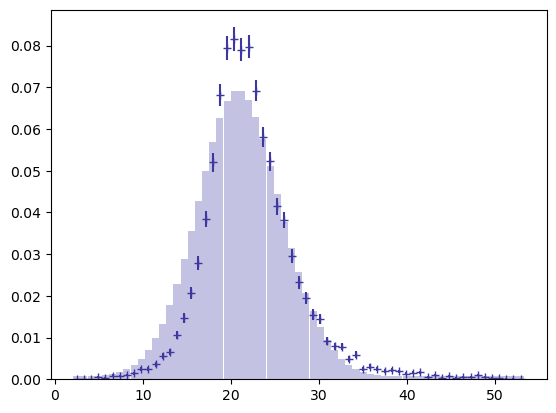

In [271]:
plt.errorbar(time0510[1:], hist0510[1:] / N0510, np.sqrt(hist0510[1:]) / N0510,
             fmt='+', label='51.0 cm/s')
plt.bar(time0510[1:], nh0510, alpha=0.3)

<BarContainer object of 63 artists>

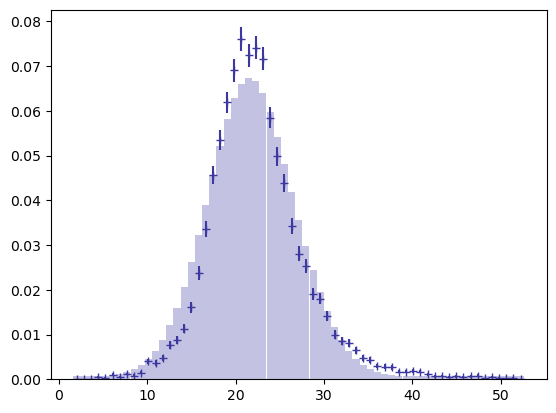

In [272]:
plt.errorbar(time0748[1:], hist0748[1:] / N0748, np.sqrt(hist0748[1:]) / N0748,
             fmt='+', label='74.8 cm/s')
plt.bar(time0748[1:], nh0748, alpha=0.3)

<BarContainer object of 63 artists>

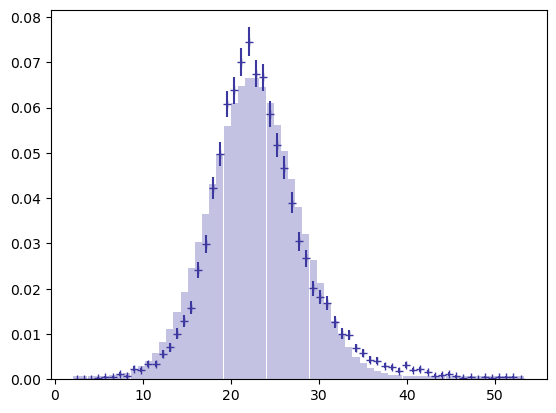

In [273]:
plt.errorbar(time1013[1:], hist1013[1:] / N1013, np.sqrt(hist1013[1:]) / N1013,
             fmt='+', label='101.3 cm/s')
plt.bar(time1013[1:], nh1013, alpha=0.3)

<BarContainer object of 63 artists>

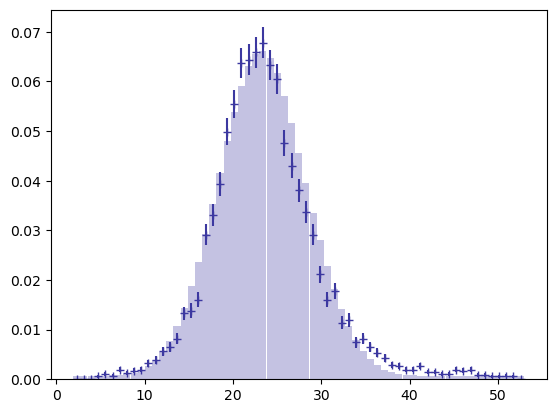

In [274]:
# 125.0 cm/s
plt.errorbar(time1250[1:], hist1250[1:] / N1250, np.sqrt(hist1250[1:]) / N1250,
             fmt='+', label='125.0 cm/s')
plt.bar(time1250[1:], nh1250, alpha=0.3)

<BarContainer object of 63 artists>

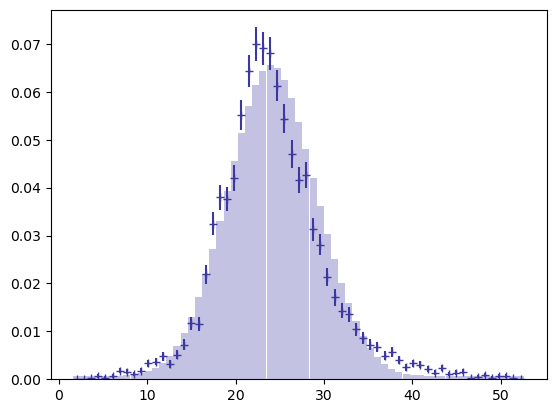

In [275]:
# 150.5 cm/s
plt.errorbar(time1505[1:], hist1505[1:] / N1505, np.sqrt(hist1505[1:]) / N1505,
             fmt='+', label='150.5 cm/s')
plt.bar(time1505[1:], nh1505, alpha=0.3)

<BarContainer object of 63 artists>

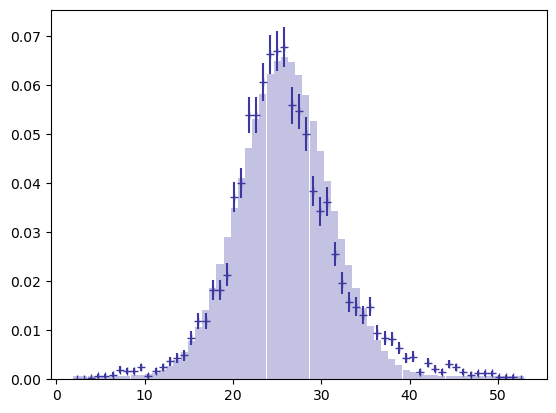

In [276]:
# 201.0 cm/s
plt.errorbar(time2010[1:], hist2010[1:] / N2010, np.sqrt(hist2010[1:]) / N2010,
             fmt='+', label='201.0 cm/s')
plt.bar(time2010[1:], nh2010, alpha=0.3)

<BarContainer object of 63 artists>

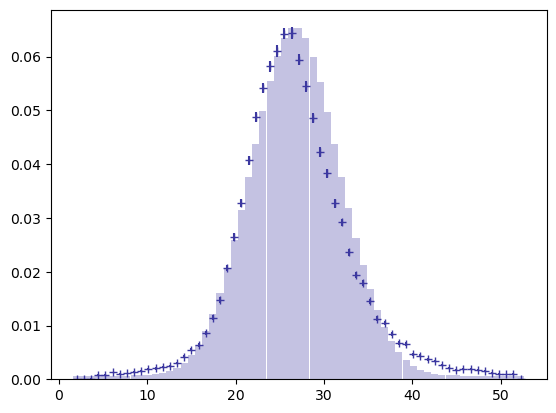

In [277]:
# 230.2 cm/s
plt.errorbar(time2302[1:], hist2302[1:] / N2302, np.sqrt(hist2302[1:]) / N2302,
             fmt='+', label='230.2 cm/s')
plt.bar(time2302[1:], nh2302, alpha=0.3)

<BarContainer object of 63 artists>

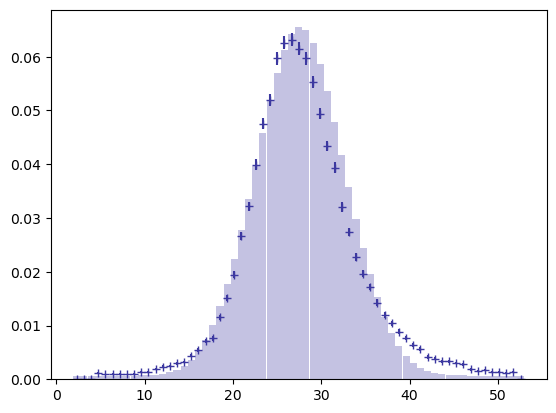

In [278]:
# 255.0 cm/s
plt.errorbar(time2550[1:], hist2550[1:] / N2550, np.sqrt(hist2550[1:]) / N2550,
             fmt='+', label='255.0 cm/s')
plt.bar(time2550[1:], nh2550, alpha=0.3)

<BarContainer object of 63 artists>

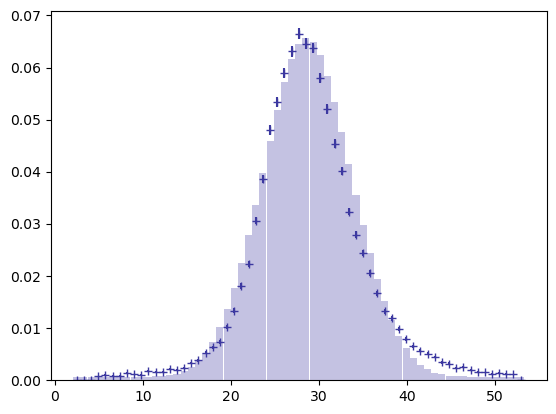

In [279]:
# 286.2 cm/s
plt.errorbar(time2862[1:], hist2862[1:] / N2862, np.sqrt(hist2862[1:]) / N2862,
             fmt='+', label='286.2 cm/s')
plt.bar(time2862[1:], nh2862, alpha=0.3)